### Dropout as a Bayesian Approximation

#### Dropout optimization

- Let's consider a network with a single hidden layer and the task of regression. A standard network would output $\widehat{y} = \sigma(x W_1 + b) W_2$.
- To use dropout we sample two binary vectors $z_1, z_2$. The elements of vector $z_i$ take value 1 with probability $0 \le p_i \le 1$ for $i = 1,2$. Given an input $x$, we set $1 - p_1$ of the elements of the input to zero: $x z_1$. The output of the first layer is given by $\sigma(x z_1 W_1 + b)$, in which we randomly set $1 - p_2$ proportion of the elements to zero, and linearly transform to give the dropout model's output $\widehat{y} = \sigma(x z_1 W_1 + b) z_2 W_2$.

--------------------

- To use the network for regression we might use the euclidean loss, $ E = \frac{1}{2N} \sum_{n=1}^N ||y_n - \widehat{y}_n||^2_2 $ During optimisation a regularisation term is often added. We often use $L_2$ regularisation weighted by some weight decay $\lambda_{decay}$, resulting in a minimisation objective,
$$
\begin{aligned} 
\label{eq:L:dropout} L_{\text{dropout}} := E + \lambda_{decay} \big( &||W_1||^2_2 + ||W_2||^2_2 \notag\\ &+ ||b||^2_2 \big). \end{aligned} 
$$
- We sample new realisations for the binary vectors $z_i$ for every input point and every forward pass thorough the model, and use the same values in the backward pass. The dropped weights $z_1W_1$ and $z_2W_2$ are scaled by $\frac{1}{p_i}$ to maintain constant output magnitude. At test time we simply use the full weights matrices $W_1,W_2,b$.

#### Gaussian Process

- By modelling our distribution over the space of functions with a Gaussian process we can analytically evaluate its corresponding posterior in regression tasks, and estimate the posterior in classification tasks. In practice what this means is that for regression we place a joint Gaussian distribution over all function values, 
$$
\begin{aligned} 
F \vert X &\sim N(z, K(X, X)) \\ Y \vert F &\sim N(F, \tau^{-1} I_N) \notag 
\end{aligned} 
$$
with some precision hyper-parameter $\tau$ and where $I_N$ is the identity matrix with dimensions $N \times N$.

------------------------

Minimising the KL divergence is the same as maximising the log evidence lower bound with respect to $\theta$: 
$$
\begin{aligned}
\label{ELBO} L_{\text{VI}} := \int q_\theta(w) \log p(Y | X, w) d w - KL(q_\theta(w) || p(w)) 
\end{aligned} 
$$

We are given a GP kernel function of the form 
$$
\begin{aligned} K(x, y) = \int N(w; 0,l^{-2}I_Q) p(b) \sigma(w^T x + b) \sigma(w^T y + b) d w d b \end{aligned}
$$
with prior length-scale $l$, some distribution $p(b)$ and $\sigma$ an element-wise non-linear function (e.g. ReLU/TanH).

We approximate this kernel function with Monte Carlo integration with $K$ terms: 
$$
\begin{aligned} \hat{K}(x, y) &= \frac{1}{K} \sum_{k=1}^K \sigma(w_k^T x + b_k) \sigma(w_k^T y + b_k) \end{aligned} 
$$
with $w_k \sim N(0,l^{-2}I_Q)$ and $b_k \sim p(b)$. This is a random kernel function. The $K$ terms in the Monte Carlo integration would correspond to $K$ hidden units in our network as we'll see below.

----------------------

We then use a variational distribution $q_\theta(w)=q_\theta(W_1)q_\theta(W_2)q_\theta(b)$ to approximate the posterior $p(w | X, Y)$: 
$$
\begin{aligned} q_\theta(W_1) = \prod_{q=1}^Q q_\theta(w_q), ~~~ q_\theta(w_q) = p_1 N(m_q, \sigma^2 I_K) + (1-p_1) N(0, \sigma^2 I_K) \notag \end{aligned}
$$
Defining the approximating distribution as a mixture of Gaussians with a small enough standard deviation (e.g. machine epsilon) results in a finite KL divergence where the term that would have diverged to infinity now takes a constant value.

We approximate the log evidence lower bound with Monte Carlo integration with a single sample $\widehat{w} \sim q_\theta(w)$: $$\begin{aligned} L_{\text{GP-MC}} \approx \log p(Y | X, \widehat{w}) - \frac{p_1 l^2}{2} ||M_1||^2_2 - \frac{p_2 l^2}{2} ||M_2||^2_2 - \frac{l^2}{2}||m||^2_2, \end{aligned}$$ 
where we approximated the second term following a theorem brought in the appendix of (Gal and Ghahramani). This is an unbiased estimator of $L_{\text{VI}}$.

Scaling the objective by the constant $\frac{1}{N \tau}$, we get the maximisation objective: $$\begin{aligned} L_{\text{GP-MC}} &\propto - \frac{1}{2 N} \sum_{n=1}^N || y_n - \widehat{y}_n ||^2_2 - \frac{p_1 l^2}{2 N \tau} ||M_1||^2_2 - \frac{p_2 l^2}{2 N \tau} ||M_2||^2_2 - \frac{l^2}{2 N \tau}||m||^2_2 \end{aligned}$$ recovering the dropout objective with appropriate model precision $\tau$ and prior length-scale $l$ for small enough $\sigma$.

------------------------

- There is a great sense of similarity between the first equation for dropout NN optimisation and the second one for GP with approximating distribution $q(\omega)$ s.t. $\omega = \{diag(\epsilon_1)M_1, diag(\epsilon_2)M_2, b\}$ with $\epsilon_l \sim Bernoulli(1-p_l) (l = 1, 2)$ (which we will refer to as a Bernoulli variational distribution or a dropout variational distribution)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import math
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


device = torch.device("cuda:0")

%matplotlib inline

In [2]:
class SimpleModel(torch.nn.Module):
    def __init__(self, dropout_rate, decay):
        super(SimpleModel, self).__init__()
        self.dropout_rate = dropout_rate
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_rate),
            torch.nn.Linear(20, 20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_rate),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):        
        return self.f(X)

In [3]:
def uncertainity_estimate(x, model, num_samples, l2):
    outputs = np.hstack([model(x).cpu().detach().numpy() for i in range(num_samples)]) # n번 inference, output.shape = [20, N]
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - model.dropout_rate) / (2. * N * model.decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [4]:
N = 200 ##  number of points
min_value = -10
max_value = 10


x_obs = np.linspace(min_value, max_value, N)
noise = np.random.normal(loc = 10, scale = 80, size = N)
y_obs =  x_obs**3 + noise

x_test = np.linspace(min_value - 10, max_value + 10, N)
y_test = x_test**3 + noise

# Normalise data:
x_mean, x_std = x_obs.mean(), x_obs.std()
y_mean, y_std = y_obs.mean(), y_obs.std()
x_obs = (x_obs - x_mean) / x_std
y_obs = (y_obs - y_mean) / y_std
x_test = (x_test - x_mean) / x_std
y_test = (y_test - y_mean) / y_std

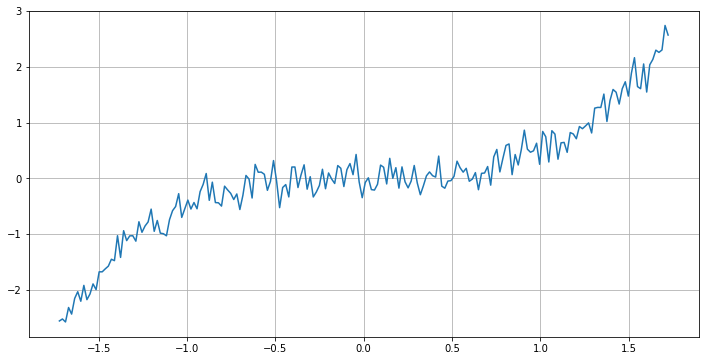

In [5]:
plt.figure(figsize=(12,6))
plt.plot(x_obs, y_obs)
plt.grid()

In [6]:
model = SimpleModel(dropout_rate=0.5, decay=1e-6).to(device)
criterion  = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=model.decay)

In [7]:
for iter in range(20000):
    y_pred = model(torch.Tensor(x_obs).view(-1,1).to(device))
    y_true = Variable(torch.Tensor(y_obs).view(-1,1).to(device))
    optimizer.zero_grad()
    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    
    if iter % 2000 == 0:
        print("Iter: {}, Loss: {:.4f}".format(iter, loss.item()))

Iter: 0, Loss: 1.1925
Iter: 2000, Loss: 0.2781
Iter: 4000, Loss: 0.2543
Iter: 6000, Loss: 0.2189
Iter: 8000, Loss: 0.2309
Iter: 10000, Loss: 0.1954
Iter: 12000, Loss: 0.2382
Iter: 14000, Loss: 0.2345
Iter: 16000, Loss: 0.2399
Iter: 18000, Loss: 0.1904


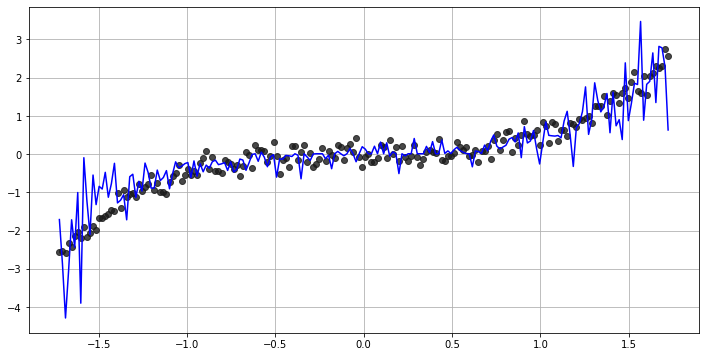

In [8]:
plt.figure(figsize=(12,6))
y_pred = model(torch.Tensor(x_obs).view(-1,1).to(device))
plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
plt.plot(x_obs, y_pred.cpu().detach().numpy(), ls="-", color="b", label="mean")
plt.grid()

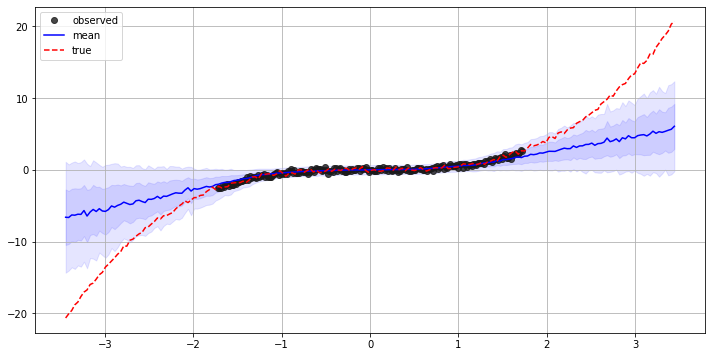

In [9]:
iters_uncertainty = 200

lengthscale = 0.01
n_std = 2 # number of standard deviations to plot
y_mean, y_std = uncertainity_estimate(torch.Tensor(x_test).view(-1,1).to(device), model, iters_uncertainty, lengthscale)

plt.figure(figsize=(12,6))
plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
plt.plot(x_test, y_mean, ls="-", color="b", label="mean")
plt.plot(x_test, y_test, ls='--', color='r', label='true')
for i in range(n_std):
    plt.fill_between( x_test,
        y_mean - y_std * ((i+1.)),
        y_mean + y_std * ((i+1.)),
        color="b",
        alpha=0.1)
plt.legend()
plt.grid()

#### MC-Dropout with MNIST

- Load Data

In [10]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [11]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(F.dropout(self.conv1(x), training=True), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x), training=True), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=True)
        x = self.fc2(x)
        return x

In [12]:
model = CNN_Model().to(device)

- Training 

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
model.train()

CNN_Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [15]:
for epoch in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):        
        data, target = data.cuda(), target.cuda()    
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] \tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(data),
                          len(train_loader.dataset),
                          100. * batch_idx / len(train_loader),
                          loss.item()))

Train Epoch: 0 [0/60000 (0%)] 	Loss: 2.300223
Train Epoch: 0 [19200/60000 (32%)] 	Loss: 1.065692
Train Epoch: 0 [38400/60000 (64%)] 	Loss: 0.435263
Train Epoch: 0 [57600/60000 (96%)] 	Loss: 0.507097
Train Epoch: 1 [0/60000 (0%)] 	Loss: 0.643757
Train Epoch: 1 [19200/60000 (32%)] 	Loss: 0.312336
Train Epoch: 1 [38400/60000 (64%)] 	Loss: 0.422601
Train Epoch: 1 [57600/60000 (96%)] 	Loss: 0.276347
Train Epoch: 2 [0/60000 (0%)] 	Loss: 0.379977
Train Epoch: 2 [19200/60000 (32%)] 	Loss: 0.314694
Train Epoch: 2 [38400/60000 (64%)] 	Loss: 0.215117
Train Epoch: 2 [57600/60000 (96%)] 	Loss: 0.279675


In [16]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target)  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
test(model)


Test set: Average loss: 0.0035, Accuracy: 9309/10000 (93.00%)



In [18]:
def mcdropout_test(model):
    model.train()
    test_loss = 0
    correct = 0
    T = 50
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output_list = []
            for i in range(T):
                output_list.append(torch.unsqueeze(model(data), 0))
            output_mean = torch.cat(output_list, 0).mean(0)
            test_loss += criterion(output_mean, target)  # sum up batch loss
            pred = output_mean.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [19]:
mcdropout_test(model)


MC Dropout Test set: Average loss: 0.0014, Accuracy: 9724/10000 (97.00%)



In [20]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=1, shuffle=True, num_workers=4)

In [21]:
r = 60
rotation_matrix = torch.Tensor([[[math.cos(r/360.0*2*math.pi), -math.sin(r/360.0*2*math.pi), 0],
                                        [math.sin(r/360.0*2*math.pi), math.cos(r/360.0*2*math.pi), 0]]]).to(device)
print(rotation_matrix)

tensor([[[ 0.5000, -0.8660,  0.0000],
         [ 0.8660,  0.5000,  0.0000]]], device='cuda:0')


In [24]:
def uncertainty_test(model):
    model.train()
    T = 50
    rotation_list = range(0, 360, 10)
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            image_list = []
            unct_list = []
            predict_list =[]
            for r in rotation_list:
                output_list = []
                rotation_matrix = torch.Tensor([[[math.cos(r/360.0*2*math.pi), -math.sin(r/360.0*2*math.pi), 0],
                                                 [math.sin(r/360.0*2*math.pi), math.cos(r/360.0*2*math.pi), 0]]]).cuda()
                grid = F.affine_grid(rotation_matrix, data.size())
                data_rotate = F.grid_sample(data, grid)
                image_list.append(data_rotate)

                for i in range(T):
                    output_list.append(torch.unsqueeze(F.softmax(model(data_rotate), dim=1), dim=0))
                output_mean = torch.cat(output_list, 0).mean(dim=0)
                output_variance = torch.cat(output_list, 0).var(dim=0).mean().item()
                confidence = output_mean.data.cpu().numpy().max()
                predict = output_mean.data.cpu().numpy().argmax()
                predict_list.append(predict)
                unct_list.append(output_variance)
#                 print ('rotation degree', str(r).ljust(3), 'Uncertainty : {:.4f} Predict : {} Softmax : {:.2f}'.format(output_variance, predict, confidence))

            plt.figure(figsize=(24, 6))
            for i in range(len(rotation_list)):
                ax = plt.subplot(2, len(rotation_list)/2, i+1)
                plt.text(0.5, -0.5, "{0:.3f}".format(unct_list[i]),
                         size=14, ha="center", transform=ax.transAxes)
                plt.axis('off')
                plt.gca().set_title('pred:'+str(predict_list[i]), size=14)
                plt.imshow(image_list[i][0, 0, :, :].data.cpu().numpy())
            plt.show()
            if idx > 10:
                break

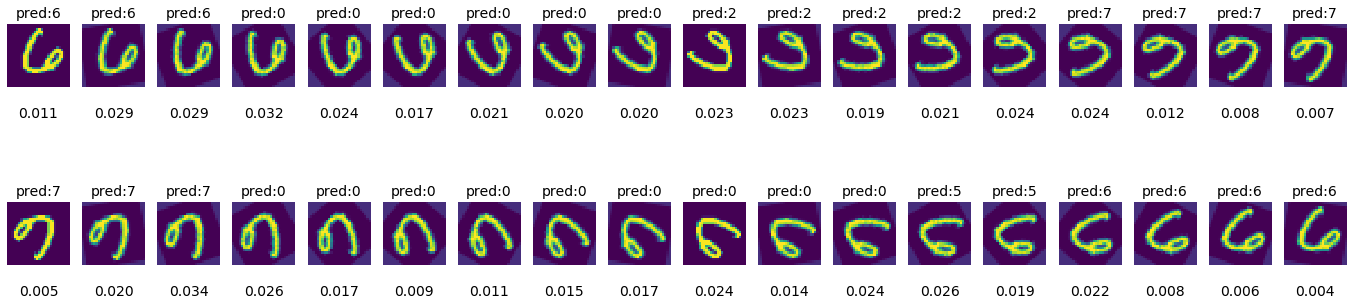

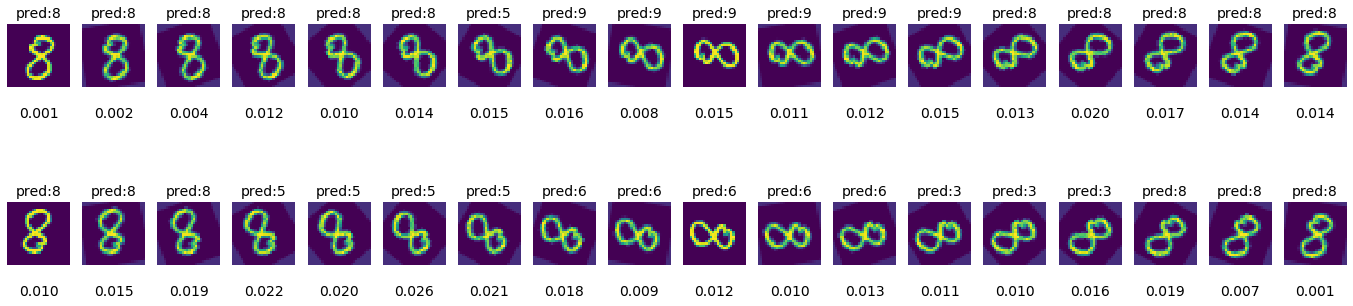

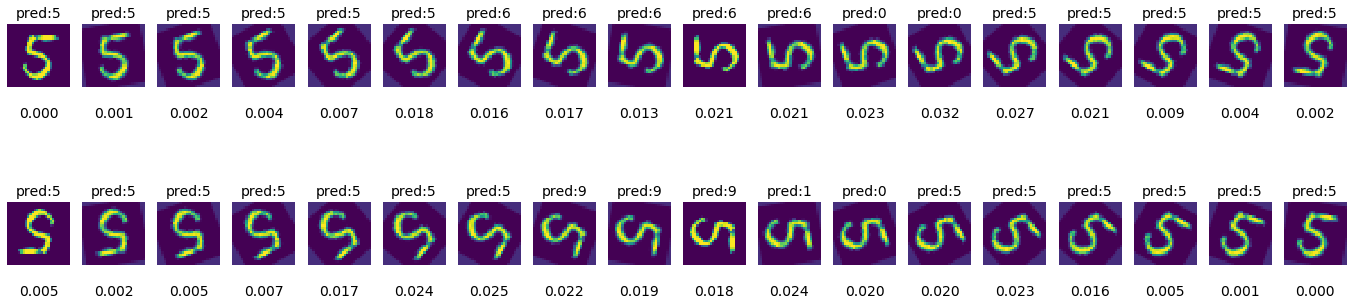

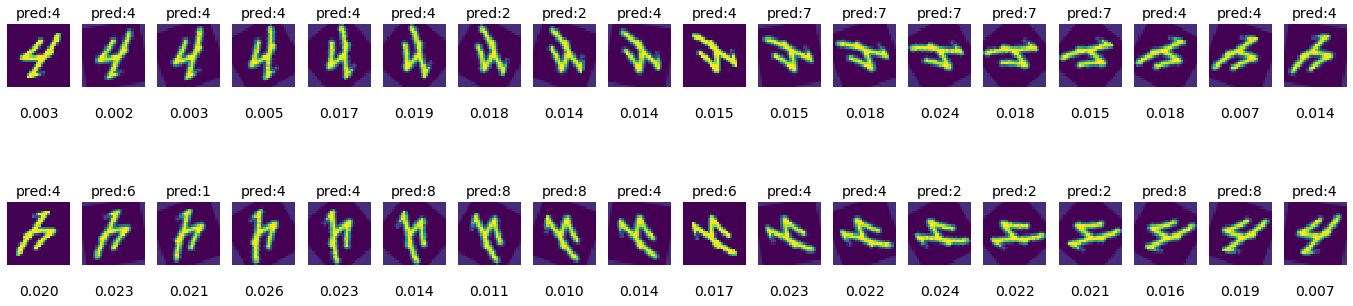

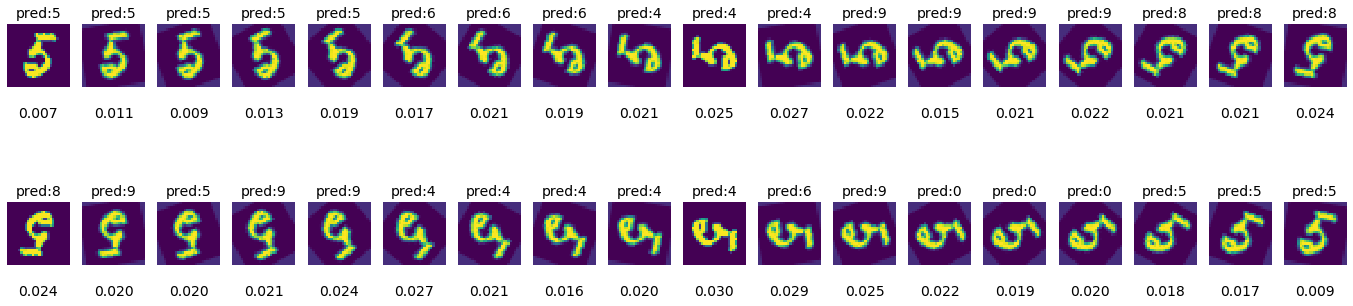

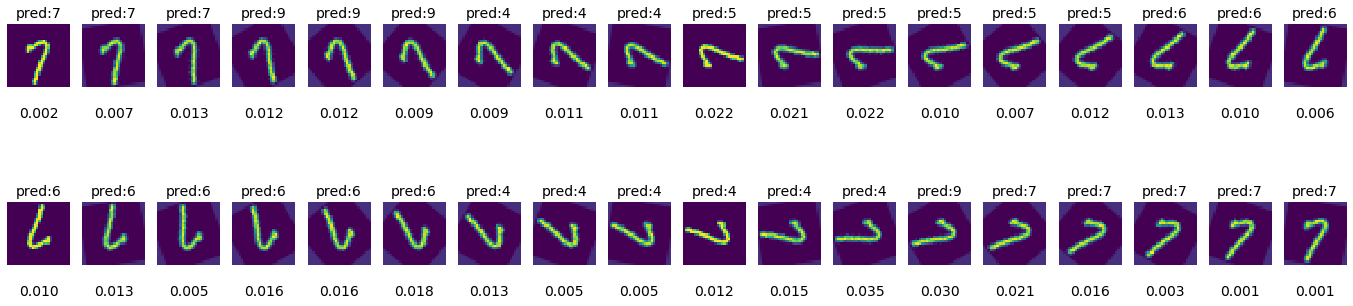

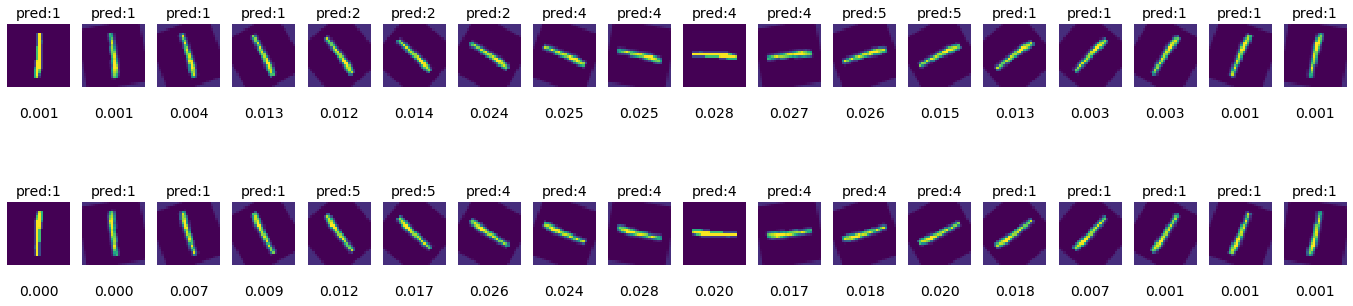

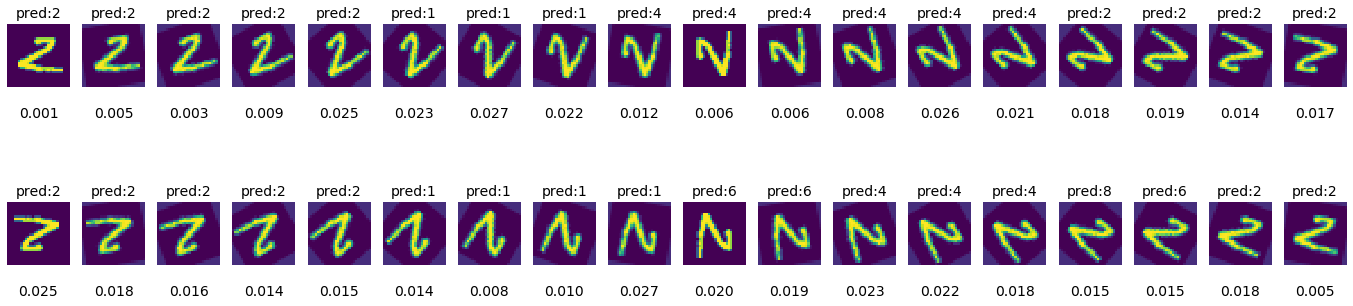

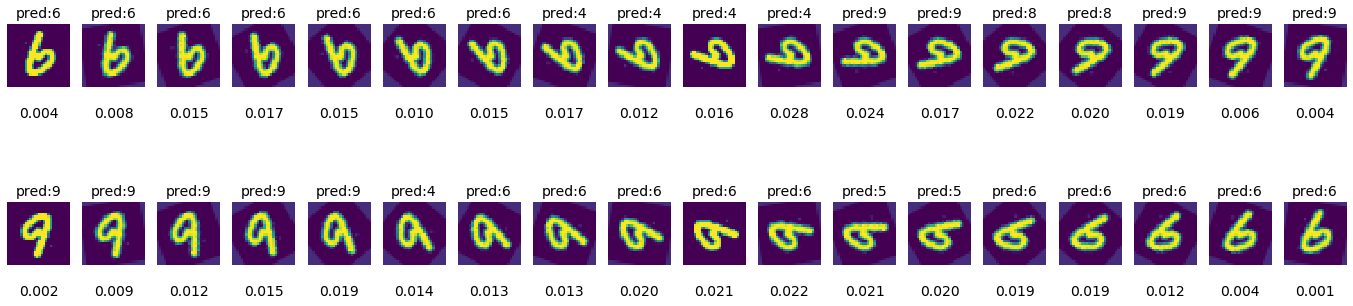

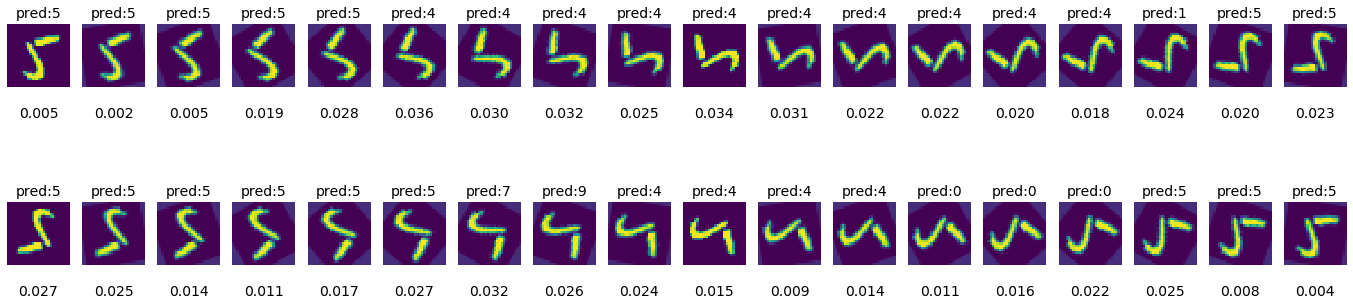

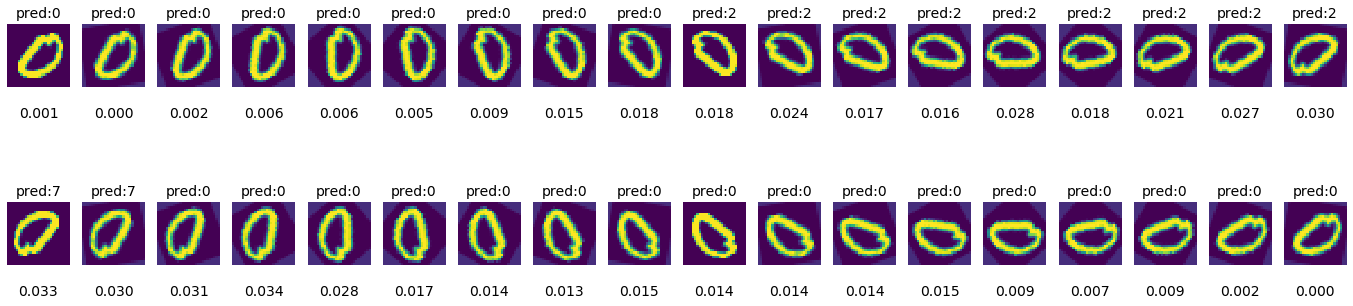

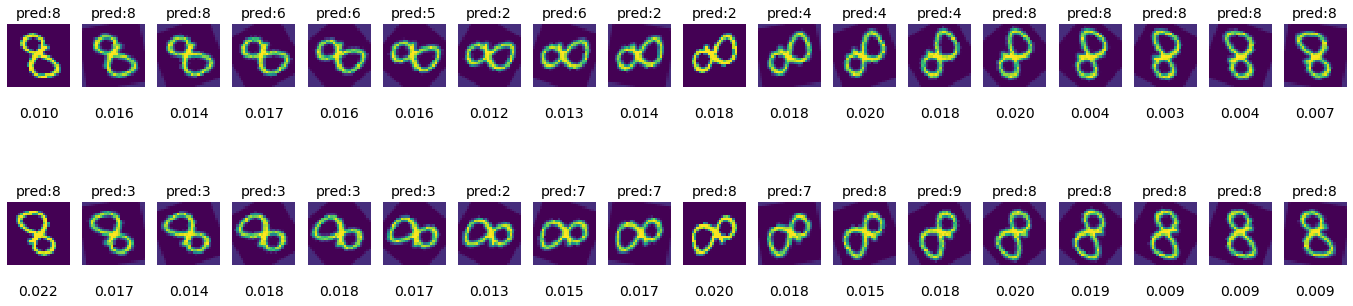

In [25]:
uncertainty_test(model)